In [1]:
import cirq
import random
import numpy as np
from cirq.contrib.svg import SVGCircuit, circuit_to_svg

#Setup

def iSWAPLayers(operations, iops, qubit):
    operations.append(cirq.ISWAP(qubit[0],qubit[1])**.5)
    operations.append(cirq.ISWAP(qubit[2],qubit[3])**.5)
    operations.append(cirq.ISWAP(qubit[1],qubit[2])**.5)
    operations.append(cirq.ISWAP(qubit[3],qubit[4])**.5)
    
    #adding to the inverse circuit stack
    iops.append(cirq.Z(qubit[0]))
    iops.append(cirq.ISWAP(qubit[0],qubit[1])**.5)
    iops.append(cirq.Z(qubit[0]))
    
    iops.append(cirq.Z(qubit[2]))
    iops.append(cirq.ISWAP(qubit[2],qubit[3])**.5)
    iops.append(cirq.Z(qubit[2]))
    
    iops.append(cirq.Z(qubit[1]))
    iops.append(cirq.ISWAP(qubit[1],qubit[2])**.5)
    iops.append(cirq.Z(qubit[1]))
    
    iops.append(cirq.Z(qubit[3]))
    iops.append(cirq.ISWAP(qubit[3],qubit[4])**.5)
    iops.append(cirq.Z(qubit[3]))

def rotationLayer(operations, iops, qubit):
    for q in qubit:
        #choose random of 3
        r = random.randint(0,2)
        angle = random.random()*np.pi
        if r == 0:
            operations.append(cirq.rx(angle)(q))
            iops.append(cirq.rx(-angle)(q))
        elif r == 1:
            operations.append(cirq.ry(angle)(q))
            iops.append(cirq.ry(-angle)(q))
        else:
            operations.append(cirq.rz(angle)(q))
            iops.append(cirq.rz(-angle)(q))

In [5]:
#THREE STEP RQC: build circuit
k = ['q0','q1','q2','q3','q4']

def rqcGenerator(addError):
    qubit = cirq.LineQubit.range(5)
    circuit = cirq.Circuit()
    oplist = []#encodes list of all operations on all qubits
    iops = []#encodes all inverse operations

    #initial op set
    for x in range(len(qubit)):
        oplist.append(cirq.H(qubit[x]))
        iops.append(cirq.H(qubit[x]))

    iSWAPLayers(oplist, iops, qubit)
    rotationLayer(oplist, iops, qubit)
    iSWAPLayers(oplist, iops, qubit)
    rotationLayer(oplist, iops, qubit)
    iSWAPLayers(oplist, iops, qubit)
    rotationLayer(oplist, iops, qubit)

    #add inverted op set
    for y in range(len(iops)):
        oplist.append(iops[len(iops)-y-1])

    #encode error
    eindex = random.randint(0,len(oplist) - 1)
    equbit = random.randint(0,len(qubit) - 1)
    error = cirq.X(qubit[equbit])

    for x in range(len(oplist)):
        if x == eindex and addError:
            circuit.append(error) #comment out this line for perfect circuits
        circuit.append(oplist[x])

    #Measure circuit
    for x in range(len(qubit)):
        circuit.append(cirq.measure(qubit[x], key=k[x]))
    
    return circuit

In [7]:
#Echo by probing each circuit once - I don't know which way is right
def probeCircuit():
    print('Circuit Fidelity by Loschmidt Echo:')
    sim = cirq.Simulator()

    circuit = rqcGenerator(False)#Generate random echo circuit with no error
    pState = sim.run(circuit)#100% fidelity
    print(circuit)
    print(pState)

    loops = 100
    pCount = 0

    for y in range(loops):
        circuit = rqcGenerator(True)#Generate new random echo circuit with random error gate
        state = sim.run(circuit)#probe it
        
        #Check if original state is recovered
        if state == pState:
            pCount += 1

    print("Fidelity: ", pCount / loops)

In [8]:
probeCircuit()

Circuit Fidelity by Loschmidt Echo:
0: ───H───iSwap───────Rz(0.903π)────────────────iSwap───────Rz(0.08π)────────────────iSwap───────Rx(0.944π)───Rx(-0.944π)───Z──────────────────────────────────────────iSwap───────Z─────────────Rz(-0.08π)────Z─────────────────────────iSwap───────Z─────────────Rz(-0.903π)───Z───────────────iSwap───────Z───H─────────M('q0')───
          │                                     │                                    │                                                                                 │                                                                 │                                                       │
1: ───H───iSwap^0.5───iSwap────────Rx(0.886π)───iSwap^0.5───iSwap───────Rz(0.534π)───iSwap^0.5───iSwap────────Rz(0.24π)─────Rz(-0.24π)────Z───iSwap───────Z────────────iSwap^0.5───Rz(-0.534π)───Z─────────────iSwap───────Z─────────────iSwap^0.5───Rx(-0.886π)───Z─────────────iSwap───────Z───iSwap^0.5───H───M('q1')─────────────
                     

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


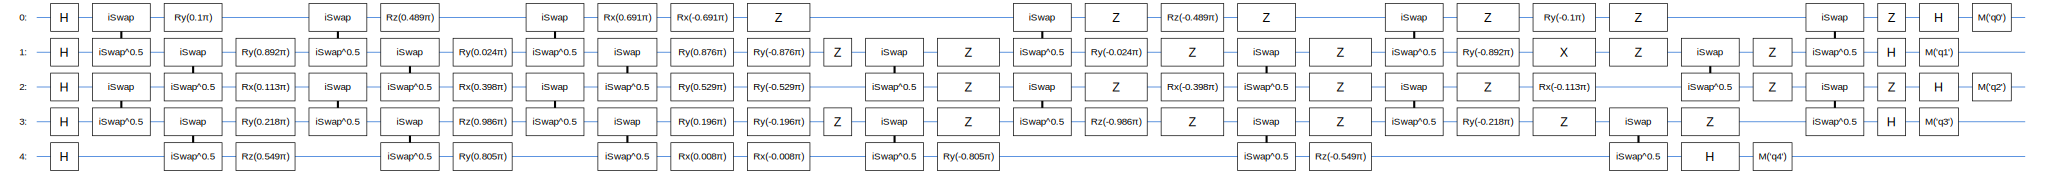

In [6]:
SVGCircuit(rqcGenerator(True))